In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
# set default matplotlib parameters for better aesthetics
plt.rcParams['figure.figsize'] = (10, 6)
# fontsize
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.linewidth'] = 2

# ============================================================
# SET YOUR DATA PATH HERE
# ============================================================
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113'
FN = 'date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004'  # without .h5 extension
h5_path = os.path.join(PTH, FN + '.h5')

# Number of z-slices per confocal volume
N_STACK = 41

print(f"Looking for: {h5_path}")
print(f"File exists: {os.path.exists(h5_path)}")

Looking for: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004.h5
File exists: True


In [2]:
def print_h5_structure(h5_path):
    """Recursively print all datasets and groups in an HDF5 file."""
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name:40s} shape={str(obj.shape):20s} dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  {name}/  (group)")

    with h5py.File(h5_path, 'r') as f:
        print(f"\nHDF5 file structure: {h5_path}\n")
        f.visititems(visitor)
        
        # Key checks
        print("\n--- Key Dataset Info ---")
        if 'img_nir' in f:
            shape = f['img_nir'].shape
            print(f"  img_nir: {shape}  (n_frames={shape[0] if len(shape)==3 else shape[2]})")
        else:
            print("  ⚠ img_nir NOT FOUND")
            
        if 'daqmx_ai' in f:
            print(f"  daqmx_ai: {f['daqmx_ai'].shape}")
        else:
            print("  ⚠ daqmx_ai NOT FOUND")
            
        if 'daqmx_di' in f:
            print(f"  daqmx_di: {f['daqmx_di'].shape}")
        else:
            print("  ⚠ daqmx_di NOT FOUND")
            
        if 'img_metadata' in f:
            for key in f['img_metadata'].keys():
                print(f"  img_metadata/{key}: {f['img_metadata'][key].shape}")
        else:
            print("  ⚠ img_metadata NOT FOUND")

print_h5_structure(h5_path)


HDF5 file structure: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004.h5

  daqmx_ai                                 shape=(3, 2400520)         dtype=float64
  daqmx_di                                 shape=(2, 2400536)         dtype=uint32
  img_metadata/  (group)
  img_metadata/img_id                      shape=(18864,)             dtype=int64
  img_metadata/img_timestamp               shape=(18864,)             dtype=int64
  img_metadata/q_iter_save                 shape=(18864,)             dtype=uint8
  img_metadata/q_recording                 shape=(18864,)             dtype=uint8
  img_nir                                  shape=(9432, 732, 968)     dtype=uint8
  pos_feature                              shape=(9432, 3, 3)         dtype=float32
  pos_stage                                shape=(9432, 2)            dtype=float64
  recording_start                          shape=()                   dtype=|S23

--- Key

In [ ]:
# Quick visualization of the signals used for synchronization
index2plot = (14000,16000) # range of samples to plot (for better visualization, since there are many samples)

lw = 2

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]

fig, axes = plt.subplots(5, 1, figsize=(16, 14), sharex=True)

labels = [
    ('daqmx_ai col 0', 'Laser Signal', 'orange'),
    ('daqmx_ai col 1', 'Piezo Signal', 'blue'),
    ('daqmx_ai col 2', 'Stimulus Signal', 'magenta'),
    ('daqmx_di col 0', 'Confocal Camera DI', 'green'),
    ('daqmx_di col 1', 'NIR Camera DI', 'red'),
]

# Plot analog inputs
for i in range(3):
    axes[i].plot(daqmx_ai[i, index2plot[0]:index2plot[1]] if daqmx_ai.shape[0] < daqmx_ai.shape[1] else daqmx_ai[index2plot[0]:index2plot[1], i],
                 color=labels[i][2], linewidth=lw)
    axes[i].set_ylabel(labels[i][1])
    axes[i].set_title(labels[i][0])

# Plot digital inputs
for i in range(2):
    axes[i+3].plot(daqmx_di[i, index2plot[0]:index2plot[1]] if daqmx_di.shape[0] < daqmx_di.shape[1] else daqmx_di[index2plot[0]:index2plot[1], i],
                   color=labels[i+3][2], linewidth=lw)
    axes[i+3].set_ylabel(labels[i+3][1])
    axes[i+3].set_title(labels[i+3][0])

axes[-1].set_xlabel('Sample Index')
plt.suptitle('Raw DAQ Signals (used for sync)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\ndaqmx_ai shape: {daqmx_ai.shape}")
print(f"daqmx_di shape: {daqmx_di.shape}")

# SYNC CODE

In [ ]:
def filter_ai_laser(ai_laser, di_camera, n_rec=1):
    n_ai, n_di = len(ai_laser), len(di_camera)
    n = min(n_ai, n_di)
    ai_laser_zstack_only = np.array(ai_laser[:n], dtype=np.float32)
    ai_laser_filter_bit = np.zeros(n, dtype=np.float32)
    trg_state = np.zeros(n, dtype=np.float64)

    n_y = n
    n_kernel = 100

    for i in range(n_y):
        start = max(0, i - n_kernel)
        stop = min(n_y, i + n_kernel)
        trg_state[i] = np.max(di_camera[start:stop])

    diff_trg_state = np.diff(trg_state)
    list_idx_start = np.where(diff_trg_state == 1)[0]
    list_idx_end = np.where(diff_trg_state == -1)[0]

    if n_rec > len(list_idx_start):
        raise ValueError("filter_ai_laser: not enough recording detected. check n_rec")
    
    list_idx_rec = np.argsort(list_idx_end - list_idx_start)[::-1][:n_rec]
    for i in list_idx_rec:
        ai_laser_filter_bit[list_idx_start[i]+1:list_idx_end[i]] = 1

    return ai_laser_filter_bit * ai_laser_zstack_only

In [ ]:
def detect_nir_timing(di_nir, img_id, q_iter_save, n_img_nir):
    # Behavior camera - FLIR
    list_nir_on = np.where(np.diff(di_nir) > 1)[0]
    list_nir_off = np.where(np.diff(di_nir) < -1)[0]
    nir_record_on = np.diff(list_nir_on) > 500
    nir_record_off = np.diff(list_nir_off) > 500

    if list_nir_on[0] > 500:  # No trigger before the first
        s_nir_start = list_nir_on[0]
    elif np.sum(nir_record_on) == 2:
        s_nir_start = list_nir_on[np.where(nir_record_on)[0][0] + 1]
    else:
        raise ValueError("More than 2 recording on detected for FLIR camera")

    if list_nir_off[-1] < len(di_nir) - 500:
        s_nir_stop = list_nir_off[-1]
    elif np.sum(nir_record_off) <= 2:
        s_nir_stop = list_nir_off[np.where(np.diff(list_nir_off) > 500)[0][-1]]
    else:
        raise ValueError("More than 2 recording off detected for FLIR camera")

    list_nir_on = [x for x in list_nir_on if s_nir_start - 5 < x < s_nir_stop + 5]
    list_nir_off = [x for x in list_nir_off if s_nir_start - 5 < x < s_nir_stop + 5]

    if len(list_nir_on) != len(list_nir_off):
        raise ValueError("length(list_nir_on) != length(list_nir_off)")

    img_id_diff = np.diff(img_id).tolist()
    img_id_diff.insert(0, 1)
    if abs(len(list_nir_on) - np.sum(np.diff(img_id))) > 3:
        raise ValueError("The detected trigger count is different from the image ID data by more than 3")
    else:
        img_id_diff[-1] += len(list_nir_on) - np.sum(np.diff(img_id)) - 1

    # idx_nir_save is a list of booleans that indicates which NIR frames to save based on the img_id_diff and q_iter_save.
    idx_nir_save = []
    for Δn, q_save in zip(img_id_diff, q_iter_save):
        if Δn == 1:
            idx_nir_save.append(q_save)
        else:
            idx_nir_save.append(q_save)
            idx_nir_save.extend([False] * (Δn - 1))

    print(f"Detected NIR frames: {len(list_nir_on)}")
    print(f"Expected NIR frames from img_id: {np.sum(np.diff(img_id))}")
    print(f"idx_nir_save (Number of NIR frames expected to save based on img_id and q_iter_save): {np.sum(idx_nir_save)}")
    print(f"Difference between detected NIR frames and expected from img_id: {len(list_nir_on) - np.sum(np.diff(img_id))}")
    # lastly, print n_img_nir
    print(f"n_img_nir (expected number of NIR frames to save): {n_img_nir}")
    if np.sum(idx_nir_save) != n_img_nir:
        raise ValueError("Detected number of NIR frames != saved NIR frames")

    return np.column_stack((list_nir_on, list_nir_off))[np.array(idx_nir_save), :]

def detect_confocal_timing(di_confocal):
    # input used to be ai_laser, but that doesn't seem right. this code is looking for stack start and stop, not session start and stop
    # Binarize laser analog signal
    di_confocal_bin = (di_confocal > np.mean(di_confocal)).astype(np.int16)

    list_confocal_on = np.where(np.diff(di_confocal_bin) == 1)[0] + 1 # find rising edges (laser on)
    list_confocal_off = np.where(np.diff(di_confocal_bin) == -1)[0] + 1 # find falling edges (laser off)

    # list_stack_start is attempting to find the start of each confocal stack by looking for rising edges that are separated by more than 150 samples. 
    # i will define my_list_stack_start, which is just the rising edges without a separation filter
    list_stack_start = list_confocal_on
    # list_stack_start = list_confocal_on[np.where(np.diff(list_confocal_on) > 150)[0] + 1] # this is empty (why??)
    # list_stack_start = np.insert(list_stack_start, 0, list_confocal_on[0])  # prepend first element

    list_stack_stop = list_confocal_off
    # list_stack_stop = list_confocal_off[np.where(np.diff(list_confocal_off) > 150)[0]]
    # list_stack_stop = np.append(list_stack_stop, list_confocal_off[-1])  # append last element

    if len(list_stack_start) != len(list_stack_stop):
        raise ValueError("n(stack_off_confocal) != n(stack_on_confocal)")

    list_stack_diff = list_stack_stop - list_stack_start
    idx_vol = np.arange(len(list_stack_diff))

    if np.diff(list_stack_diff)[-1] < -3:
        idx_vol = np.arange(len(list_stack_diff) - 1)

    return list_stack_start[idx_vol], list_stack_stop[idx_vol]



In [ ]:
def sync_timing_(di_confocal, di_nir, ai_laser, img_id, q_iter_save, n_img_nir):
    timing_stack = np.column_stack(detect_confocal_timing(di_confocal))
    timing_nir = detect_nir_timing(di_nir, img_id, q_iter_save, n_img_nir)

    confocal_to_nir = []
    nir_to_confocal = np.zeros(timing_nir.shape[0], dtype=int)

    for i in range(timing_stack.shape[0]):
        start_, end_ = timing_stack[i, :]

        nir_on_bit = (start_ < timing_nir[:, 0]) & (timing_nir[:, 0] < end_)
        nir_off_bit = (start_ < timing_nir[:, 1]) & (timing_nir[:, 1] < end_)

        idx_ = np.where(nir_on_bit & nir_off_bit)[0]
        confocal_to_nir.append(idx_)

        nir_to_confocal[idx_] = i + 1  # Adjust for 1-based indexing in Julia

    return confocal_to_nir, nir_to_confocal, timing_stack, timing_nir

In [ ]:
def sync_timing(path_h5, n_rec=1):
    with h5py.File(path_h5, 'r') as f:
        daqmx_ai = f['daqmx_ai'][:]
        daqmx_di = f['daqmx_di'][:]
        n_img_nir = f['img_nir'].shape[0]
        img_metadata = f['img_metadata']
        img_timestamp = img_metadata['img_timestamp'][:]
        img_id = img_metadata["img_id"][:]
        q_iter_save = img_metadata["q_iter_save"][:]
        
    print(f"Loaded daqmx_ai with shape: {daqmx_ai.shape}")
    print(f"Loaded daqmx_di with shape: {daqmx_di.shape}")
    print(f"Number of NIR images: {n_img_nir}")
    
    ai_laser = filter_ai_laser(daqmx_ai[0,:], daqmx_di[0,:], n_rec)
    ai_piezo = daqmx_ai[1,:]
    ai_stim = daqmx_ai[2,:]
    di_confocal = daqmx_di[0,:].astype(np.float32)
    di_nir = daqmx_di[1,:].astype(np.float32)

    confocal_to_nir, nir_to_confocal, timing_stack, timing_nir = sync_timing_(di_confocal, di_nir, ai_laser, img_id, q_iter_save, n_img_nir)
    
    return ai_laser, confocal_to_nir, nir_to_confocal, timing_stack, timing_nir
    

In [ ]:
ai_laser, confocal_to_nir, nir_to_confocal, timing_stack, timing_nir = sync_timing(h5_path, n_rec=1)

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(ai_laser, label='Filtered Laser Signal', color='orange')
plt.title('Filtered Laser Signal (used for confocal stack timing)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(timing_stack[:, 0], label='Confocal Stack Start', color='green')
plt.plot(timing_stack[:, 1], label='Confocal Stack Stop', color='red')
plt.title('Detected Confocal Stack Timing', fontsize=14, fontweight='bold')
plt.xlabel('Stack Index')
plt.ylabel('Sample Index')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.scatter(np.arange(100), timing_nir[0:100, 0], label='NIR Recording Start', color='blue')
plt.scatter(np.arange(100), timing_nir[0:100, 1], label='NIR Recording Stop', color='purple')
plt.title('Detected NIR Recording Timing', fontsize=14, fontweight='bold')
plt.xlabel('NIR Frame Index')
# plotted on the yaxis is the sample index of the start and stop of each NIR recording, which should align with the confocal stack timing if everything is correct.
plt.ylabel('Sample Index')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(12, 4))
# plt.plot(confocal_to_nir, 'o-', label='Confocal to NIR Mapping')
# plt.title('Confocal to NIR Mapping', fontsize=14, fontweight='bold')
# plt.xlabel('Sample Index')
# plt.ylabel('NIR Frame Index')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 4))
# plt.plot(nir_to_confocal, 'o-', label='NIR to Confocal Mapping')
# plt.title('NIR to Confocal Mapping', fontsize=14, fontweight='bold')
# plt.xlabel('Sample Index')
# plt.ylabel('Confocal Frame Index')
# plt.tight_layout()
# plt.show()

In [ ]:
plt.figure()
plt.plot(ai_laser)
plt.show()

In [ ]:
ai_laser, di_camera = daqmx_ai[0,:], daqmx_di[0,:]
n_rec = 1

n_ai, n_di = len(ai_laser), len(di_camera)
n = min(n_ai, n_di)
ai_laser_zstack_only = np.array(ai_laser[:n], dtype=np.float32)
ai_laser_filter_bit = np.zeros(n, dtype=np.float32)
trg_state = np.zeros(n, dtype=np.float64)

n_y = n
n_kernel = 100

for i in range(n_y):
    start = max(0, i - n_kernel)
    stop = min(n_y, i + n_kernel)
    trg_state[i] = np.max(di_camera[start:stop])

diff_trg_state = np.diff(trg_state)
list_idx_start = np.where(diff_trg_state == 1)[0]
list_idx_end = np.where(diff_trg_state == -1)[0]

In [ ]:
list_idx_end

In [ ]:
plt.figure()
plt.plot(diff_trg_state)
plt.show()

# SYNC.py

In [ ]:
import importlib
import sys

In [ ]:
import sync
_ = importlib.reload(sys.modules['sync'])
confocal_to_nir, nir_to_confocal, timing_stack, timing_nir = sync.sync_timing_from_h5(h5_path, n_rec=1)

In [ ]:
confocal_to_nir

In [ ]:
confocal_to_nir_not_empty = [x for x in confocal_to_nir if len(x) > 0]
print(f"Number of confocal stacks with NIR mapping: {len(confocal_to_nir_not_empty)}")

plt.figure(figsize=(12, 4))
plt.plot(confocal_to_nir_not_empty, 'o', label='Confocal to NIR Mapping')
plt.title('Confocal to NIR Mapping', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('NIR Frame Index')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(nir_to_confocal, 'o', label='NIR to Confocal Mapping')
plt.title('NIR to Confocal Mapping', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Confocal Frame Index')
plt.tight_layout()
plt.show()

In [ ]:
confocal_to_nir_not_empty = [x for x in confocal_to_nir if len(x) > 0]
print(f"Number of confocal stacks with NIR mapping: {len(confocal_to_nir_not_empty)}")

In [ ]:
confocal_to_nir

# V3

In [3]:
# Assuming 'signal' is your numpy array 
# and 'peaks' is your array of peak indices
def find_wave_starts(signal, peaks):
    starts = []
    
    for i in range(len(peaks)):
        if i == 0:
            # For the first peak, search from the beginning of the signal
            start_idx = np.argmin(signal[:peaks[i]])
        else:
            # Search between the previous peak and current peak
            search_range = signal[peaks[i-1] : peaks[i]]
            # Add the offset of the previous peak to get the absolute index
            start_idx = np.argmin(search_range) + peaks[i-1]
            
        starts.append(start_idx)
        
    return np.array(starts)

# Example usage:
# start_indices = find_wave_starts(my_signal, peak_indices)

Loaded daqmx_ai with shape: (3, 2400520)
Loaded daqmx_di with shape: (2, 2400536)
img_id with shape: (18864,)
img_timestamp with shape: (18864,)
q_iter_save with shape: (18864,)
Number of NIR images: 9432


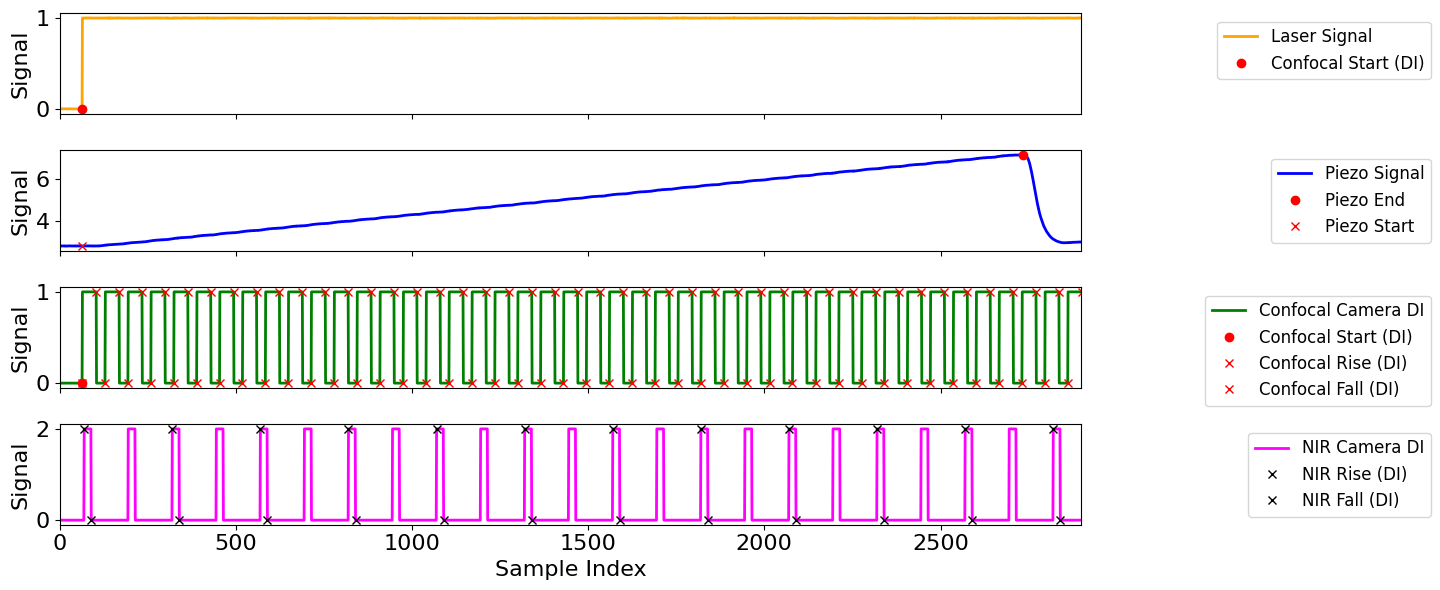

In [ ]:
# main code

from scipy.stats import mode
from sync import detect_nir_timing
from scipy.signal import find_peaks


with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]
    n_img_nir = f['img_nir'].shape[0]
    img_metadata = f['img_metadata']
    img_timestamp = img_metadata['img_timestamp'][:]
    img_id = img_metadata["img_id"][:]
    q_iter_save = img_metadata["q_iter_save"][:]
        
print(f"Loaded daqmx_ai with shape: {daqmx_ai.shape}")
print(f"Loaded daqmx_di with shape: {daqmx_di.shape}")
print(f"img_id with shape: {img_id.shape}")
print(f"img_timestamp with shape: {img_timestamp.shape}")
print(f"q_iter_save with shape: {q_iter_save.shape}")
print(f"Number of NIR images: {n_img_nir}")

di_confocal = daqmx_di[0,:].astype(np.float32)
di_nir = daqmx_di[1,:].astype(np.float32)
ai_laser = daqmx_ai[0,:].astype(np.float32)
ai_piezo = daqmx_ai[1,:].astype(np.float32)
ai_stim = daqmx_ai[2,:].astype(np.float32)


# get stack start (rise) and stop (fall) indices from di_confocal, which is the digital input from the confocal camera that should indicate when each stack starts and stops.
di_confocal_rise = np.where(np.diff(di_confocal) > 0.0)[0]
di_confocal_fall = np.where(np.diff(di_confocal) < 0.0)[0]
confocal_start_idx = di_confocal_rise[0] # recording start in confocal
confocal_timing = np.concatenate((di_confocal_rise.reshape(-1,1), di_confocal_fall.reshape(-1,1)), axis=1) # combine confocal rise and fall indices to get confocal stack timing

# confocal_start_idx from di should be the same as confocal_start_idx from ai_laser, which is what we were using before. let's check that.
ai_laser_rise = np.where(np.diff(ai_laser) > 0.5)[0]    
confocal_start_idx_ai = ai_laser_rise[0]

assert (confocal_start_idx - confocal_start_idx_ai) == 0, "Confocal start index from DI and AI do not match"

# get nir recording start (rise) and stop (fall) indices from di_nir, which is the digital input from the NIR camera that should indicate when each NIR recording starts and stops.
nir_timing = detect_nir_timing(di_nir, img_id, q_iter_save, n_img_nir)
di_nir_rise = nir_timing[:, 0]
di_nir_fall = nir_timing[:, 1]
# di_nir_rise = np.where(np.diff(di_nir) > 0.5)[0]
# di_nir_fall = np.where(np.diff(di_nir) < -0.5)[0]
nir_start_idx = di_nir_rise[0] # recording start in NIR
    
# find piezo start stop (fall) times from ai_piezo. ai_piezo is a ramping signal that indicates when the piezo is moving, which should correspond to when the confocal camera is acquiring a stack. we can use this to check if the confocal stack timing from di_confocal matches the piezo movement timing from ai_piezo.
# need to first find the peaks using a peak finding algorithm, since the piezo signal is not a perfect ramp and has some noise. we can use scipy.signal.find_peaks for this.

peaks, properties = find_peaks(
    ai_piezo, 
    distance=100,
    prominence=1.0
) # find peaks in piezo signal, which should correspond to stack acquisition. distance is set to 400 samples
piezo_start_idx = peaks[0] # recording start in piezo, which should correspond
piezo_start_idx_from_peak = find_wave_starts(ai_piezo, peaks)
# piezo_start_idx_from_peak[0] = peaks[0] - mode(peaks - piezo_start_idx_from_peak)[0]
piezo_start_idx_from_peak[0] = confocal_start_idx
piezo_timing = np.concatenate((piezo_start_idx_from_peak.reshape(-1,1), peaks.reshape(-1,1)), axis=1) # combine piezo start and stop indices to get confocal stack timing


# I have confocal_timing, piezo_timing, nir_timing


# for each row in confocal_timing, determine the row in piezo_timing that it falls into. this will give us the confocal to piezo mapping, which we can use to check if the confocal stack timing from di_confocal matches the piezo movement timing from ai_piezo.
confocal_timing_stack_number = np.full(confocal_timing.shape[0], np.nan, dtype=float)
for i in range(confocal_timing.shape[0]):
    confocal_start, confocal_stop = confocal_timing[i]
    for j in range(piezo_timing.shape[0]):
        piezo_start, piezo_stop = piezo_timing[j]
        if piezo_start <= confocal_start <= piezo_stop:
            confocal_timing_stack_number[i] = j + 1 # add 1 to make it 1-based indexing like in Julia
            break

# for each row in nir_timing, determine the row in piezo_timing that it falls into. this will give us the nir to piezo mapping, which we can use to check if the nir recording timing from di_nir matches the piezo movement timing from ai_piezo.
nir_timing_stack_number = np.full(nir_timing.shape[0], np.nan, dtype=float)
for i in range(nir_timing.shape[0]):
    nir_start, nir_stop = nir_timing[i]
    for j in range(piezo_timing.shape[0]):
        piezo_start, piezo_stop = piezo_timing[j]
        if piezo_start <= nir_start <= piezo_stop:
            nir_timing_stack_number[i] = j + 1 # add 1 to make it 1-based indexing like in Julia
            break

# for each row in nir_timing, determine the row in confocal_timing that it falls into. this will give us the nir to confocal mapping, which we can use to check if the nir recording timing from di_nir matches the confocal stack timing from di_confocal.
nir_to_confocal_trigger_number = np.full(nir_timing.shape[0], np.nan, dtype=float)
for i in range(nir_timing.shape[0]):
    nir_start, nir_stop = nir_timing[i]
    for j in range(confocal_timing.shape[0]):
        confocal_start, confocal_stop = confocal_timing[j]
        if confocal_start <= nir_start <= confocal_stop:
            nir_to_confocal_trigger_number[i] = j + 1 # add 1 to make it 1-based indexing like in Julia
            break
    
# make a new array that is just confocal_timing_stack_number, but each set of rows that correspond to the same stack number get incremented starting with 0, and it resets at each stack number
confocal_timing_stack_number_incremented = np.full(confocal_timing_stack_number.shape, np.nan, dtype=float)
current_stack_number = 0
current_increment = 0
for i in range(confocal_timing_stack_number.shape[0]):
    if np.isnan(confocal_timing_stack_number[i]):
        continue
    elif confocal_timing_stack_number[i] == current_stack_number:
        confocal_timing_stack_number_incremented[i] = current_increment
        current_increment += 1
    else:
        current_stack_number = confocal_timing_stack_number[i]
        current_increment = 0
        confocal_timing_stack_number_incremented[i] = current_increment
        current_increment += 1

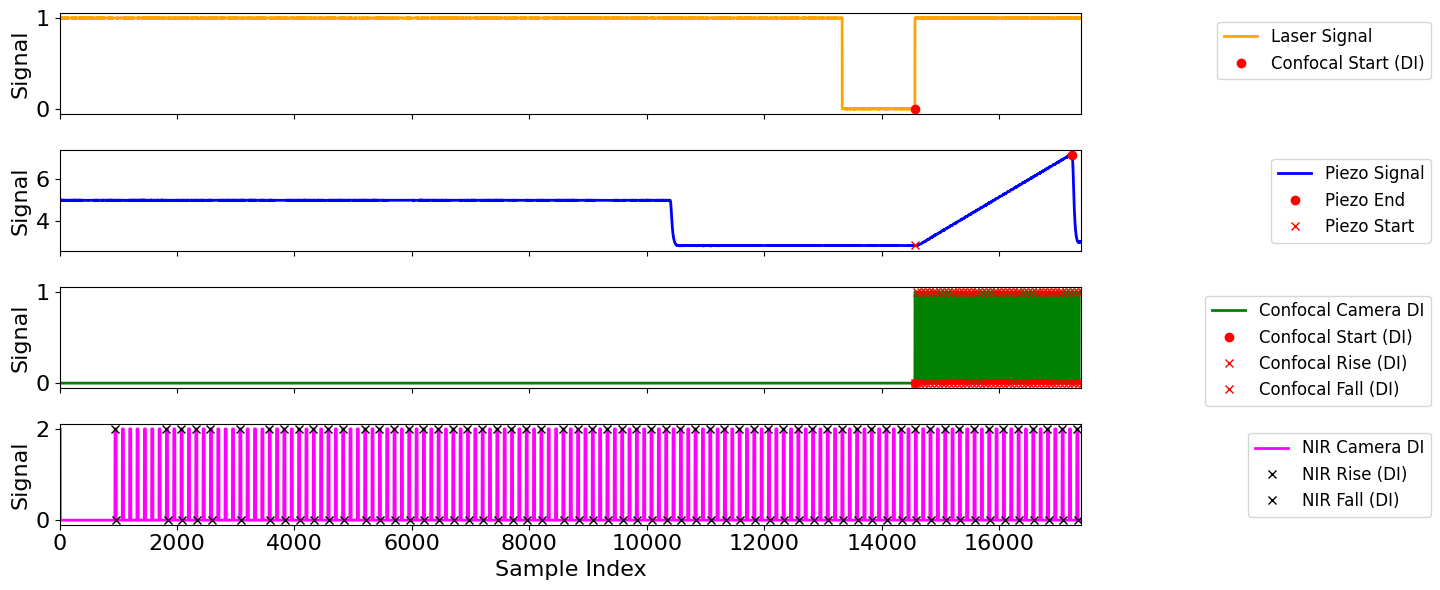

In [21]:
zoom = (0, 17400)
# zoom = (0, 20000)
fig, axs = plt.subplots(4, 1, figsize=(15,6), sharex=True)
axs[0].plot(ai_laser[zoom[0]:zoom[1]], label='Laser Signal', color='orange')
# plot laser signal start idx
axs[0].plot(confocal_start_idx_ai - zoom[0], ai_laser[confocal_start_idx_ai], 'o', label='Confocal Start (DI)', color='red')
axs[1].plot(ai_piezo[zoom[0]:zoom[1]], label='Piezo Signal', color='blue')
# axs[2].plot(ai_stim[zoom[0]:zoom[1]], label='Stimulus Signal', color='magenta')

axs[2].plot(di_confocal[zoom[0]:zoom[1]], label='Confocal Camera DI', color='green')
# plot confocal start idx
axs[2].plot(confocal_start_idx - zoom[0], di_confocal[confocal_start_idx], 'o', label='Confocal Start (DI)', color='red')
# plot confocal rise and fall times
axs[2].plot(di_confocal_rise - zoom[0], di_confocal[di_confocal_rise], 'x', label='Confocal Rise (DI)', color='red')
axs[2].plot(di_confocal_fall - zoom[0], di_confocal[di_confocal_fall], 'x', label='Confocal Fall (DI)', color='red')

axs[3].plot(di_nir[zoom[0]:zoom[1]], label='NIR Camera DI', color='magenta')
# plot nir rise and fall times
axs[3].plot(di_nir_rise - zoom[0], di_nir[di_nir_rise], 'x', label='NIR Rise (DI)', color='black')
axs[3].plot(di_nir_fall - zoom[0], di_nir[di_nir_fall], 'x', label='NIR Fall (DI)', color='black')

# plot piezo peaks
# find number of peaks within zoom range
num_peaks_in_zoom = np.sum((peaks >= zoom[0]) & (peaks <= zoom[1]))
axs[1].plot(peaks[0:num_peaks_in_zoom]-zoom[0], ai_piezo[peaks[0:num_peaks_in_zoom]], 'o', label='Piezo End', color='red')
# plot piezo start from peak
axs[1].plot(np.array(piezo_start_idx_from_peak[0:num_peaks_in_zoom])-zoom[0], ai_piezo[piezo_start_idx_from_peak[0:num_peaks_in_zoom]], 'x', label='Piezo Start', color='red')
for ax in axs:
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1), fontsize=12)
    ax.set_ylabel('Signal')
axs[-1].set_xlabel('Sample Index')
# plt.suptitle('Raw DAQ Signals (used for sync)', fontsize=14, fontweight='bold')
plt.xlim(0, zoom[1]-zoom[0])
plt.tight_layout()
plt.show()

In [ ]:
confocal_timing

array([[  14564,   14604],
       [  14629,   14669],
       [  14694,   14734],
       ...,
       [2368469, 2368509],
       [2368535, 2368574],
       [2368600, 2368640]], shape=(36186, 2))

In [ ]:
piezo_timing

array([[  14564,   17235],
       [  17349,   19902],
       [  20019,   22568],
       ...,
       [2361888, 2364441],
       [2364559, 2367104],
       [2367222, 2369006]], shape=(883, 2))

In [ ]:
nir_timing

array([[    944,     964],
       [   1819,    1839],
       [   2069,    2089],
       ...,
       [2398757, 2398777],
       [2399007, 2399027],
       [2399257, 2399277]], shape=(9432, 2))

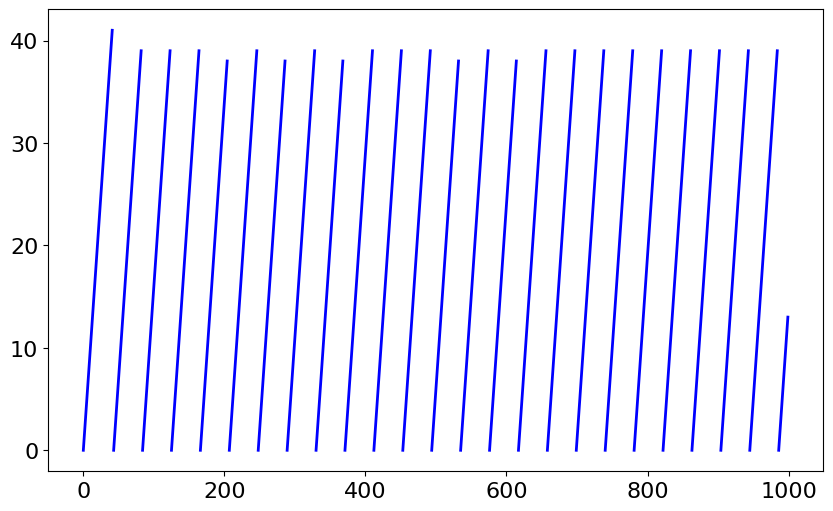

In [6]:
confocal_timing_stack_number_incremented

plt.figure()
plt.plot(confocal_timing_stack_number_incremented[0:1000], label='Confocal Stack Number Incremented', color='blue')
# plt.plot(nir_timing_stack_number, label='NIR Stack Number', color='orange')
# plt.plot(nir_to_confocal_trigger_number, label='NIR to Confocal Trigger Number', color='green')
# plt.legend()
plt.show()

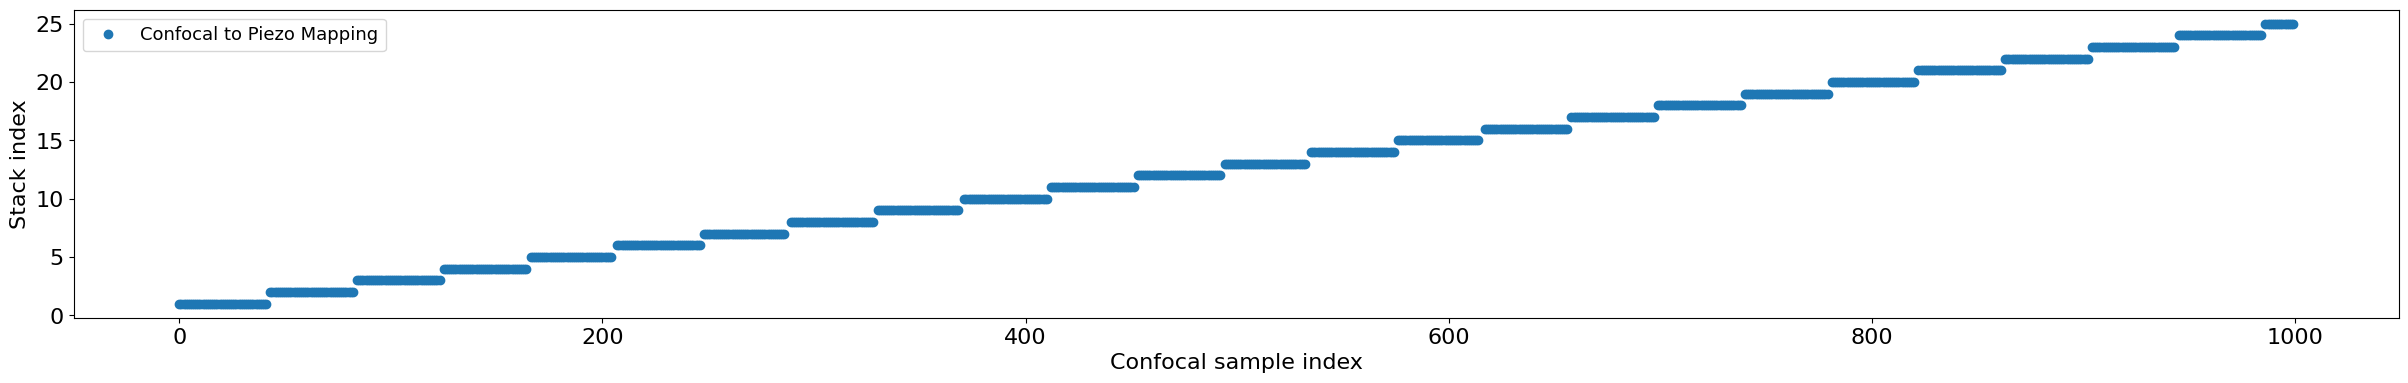

In [ ]:
plt.figure(figsize=(30,4)   )
plt.plot(confocal_timing_stack_number[0:1000], 'o', label='Confocal to Piezo Mapping')
plt.xlabel('Confocal sample index')
plt.ylabel('Stack index')
plt.legend()
plt.show()

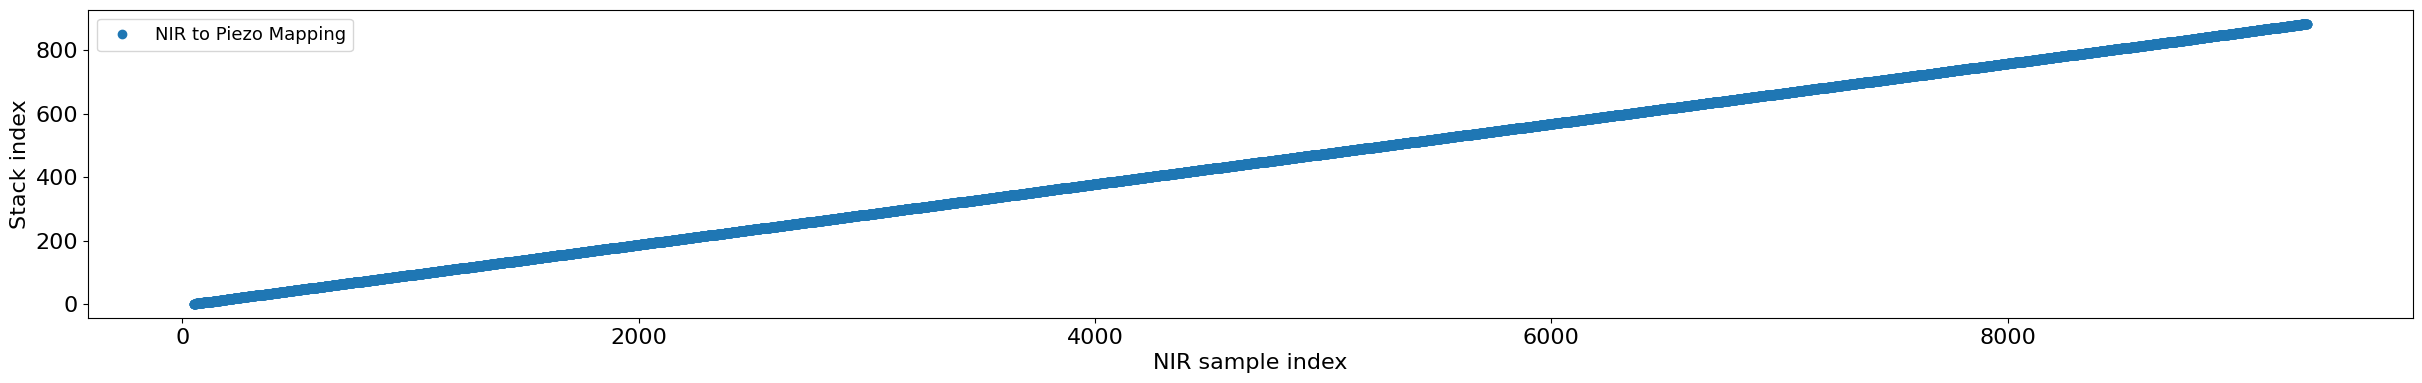

In [ ]:
plt.figure(figsize=(30,4)   )
plt.plot(nir_timing_stack_number, 'o', label='NIR to Piezo Mapping')
plt.xlabel('NIR sample index')
plt.ylabel('Stack index')
plt.legend()
plt.show()

In [5]:
print(confocal_timing_stack_number.shape)
print(confocal_timing_stack_number_incremented.shape)

(36186,)
(36186,)


In [ ]:
with h5py.File(h5_path, 'r') as f:
    im = f.get('img_nir')[:] # THW
sz = im.shape

fps = 20.0  # frames per second

print('Video shape: ', sz)

nframes = im.shape[0]
record_duration = nframes / fps # in seconds

print('Recording duration (s): ', record_duration)

Video shape:  (9432, 732, 968)
Recording duration (s):  471.6


In [20]:
nframes

9432

In [22]:
nir_timing

array([[    944,     964],
       [   1819,    1839],
       [   2069,    2089],
       ...,
       [2398757, 2398777],
       [2399007, 2399027],
       [2399257, 2399277]], shape=(9432, 2))

In [24]:
confocal_timing_stack_number

array([  1.,   1.,   1., ..., 883., 883., 883.], shape=(36186,))

In [25]:
confocal_timing.shape

(36186, 2)

In [33]:

# save im, which is of shape (frame, height, width) as a .mp4 video
import cv2
out_fn = 'nir_video.mp4'
if not os.path.exists(PTH):
    os.makedirs(PTH)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(out_fn, fourcc, fps, (sz[2], sz[1]), isColor=False)
# save video
for i in range(nframes):
# for i in range(500):
    # skip frame if recording has not started based on confocal_timing and nir_timing
    nir_start, nir_end = nir_timing[i, 0], nir_timing[i, 1]
    if nir_start < confocal_timing[0, 0]:
        continue

    # find the confocal_timing row for this nir frame
    confocal_row = np.where((confocal_timing[:,0] <= nir_start) & (confocal_timing[:,1] >= nir_start))[0]
    if len(confocal_row) == 0:
        continue
    confocal_row = confocal_row[0]
    
    stack_number = confocal_timing_stack_number[confocal_row]
    plane_number = confocal_timing_stack_number_incremented[confocal_row]



    # print status every 100 frames
    if i % 100 == 0:
        print('Saving frame: ', i, ' / ', nframes)
    frame = im[i,:,:]
    frame = (frame / np.max(frame) * 255).astype(np.uint8)
    # overlay frame with text of frame number and time in seconds
    time_sec = i / fps
    text = f'Frame: {i}  Time: {time_sec:.2f} sec  Stack: {stack_number if not np.isnan(stack_number) else "N/A"}  Plane: {plane_number if not np.isnan(plane_number) else "N/A"} '
    # text = f'Frame: {i}  Time: {time_sec:.2f} sec  Stack: {confocal_timing_stack_number[i] if i < len(confocal_timing_stack_number) else "N/A"}  Plane: {confocal_timing_stack_number_incremented[i] if i < len(confocal_timing_stack_number_incremented) else "N/A"} '
    cv2.putText(frame, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255), 2)
    # frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    out.write(frame)



out.release()
print('Saved video to: ', out_fn)


Saving frame:  200  /  9432
Saving frame:  300  /  9432
Saving frame:  700  /  9432
Saving frame:  1100  /  9432
Saving frame:  1200  /  9432
Saving frame:  1300  /  9432
Saving frame:  1400  /  9432
Saving frame:  1500  /  9432
Saving frame:  1600  /  9432
Saving frame:  1900  /  9432
Saving frame:  2100  /  9432
Saving frame:  2200  /  9432
Saving frame:  2300  /  9432
Saving frame:  2400  /  9432
Saving frame:  2500  /  9432
Saving frame:  2600  /  9432
Saving frame:  3300  /  9432
Saving frame:  3400  /  9432
Saving frame:  3500  /  9432
Saving frame:  3800  /  9432
Saving frame:  3900  /  9432
Saving frame:  4000  /  9432
Saving frame:  4100  /  9432
Saving frame:  4200  /  9432
Saving frame:  4300  /  9432
Saving frame:  4400  /  9432
Saving frame:  4500  /  9432
Saving frame:  4800  /  9432
Saving frame:  4900  /  9432
Saving frame:  5000  /  9432
Saving frame:  5100  /  9432
Saving frame:  5200  /  9432
Saving frame:  5300  /  9432
Saving frame:  5800  /  9432
Saving frame:  59

In [32]:
confocal_row

np.int64(0)

# TODO

- put all this code together to deliver a synced recording
  - will need to figure out what params, data_dicts, and outputs from get_timing_info in the antsun notebook